# Working with `chatlogs.txt`

*All imports are consolidated at the top of this notebook in the cell below.*

In [30]:
# All the imports upfront
import re
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA

# And then the MPL import and settings
import matplotlib.pyplot as plt
# Set plt parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)

# Acquisition and Description of Raw Data

One of the files available in the Gab archive made available a few years ago appears to be a single file made up of chat logs, `chatlogs.txt`. The rest of the archive is made up of SQL files: accounts, groups, statuses, verifications. The `statuses.sql` looks promising but at 67GB is quite large. In contrast, `chatlogs.txt` is a mere 10MB and contains 96,100 lines.. As the header (see below) notes, chatlogs has: "70593 messages in 19683 chats with 15322 users."

My first step was to find out what the file looked like, I opened it in Visual Studio Code and scanned the contents to see how the data was structured. (Below is what the file looked like using Python.)

- Most of the chat log entries were single lines and looked like this:
> `2020-12-30T14:23:54 @lovelymiss[VPD]: I haven't seen that one either.  I've watched demons a bunch though`
- There were a lot of lines that contain three dashes and a number, e.g., `--- 371308`, and nothing else.
- There were also some multi-line entries that would need to be conslidated with the date-time and user line of whih they were a part.

## Planned Actions

- I would eventually like, I think, each entry to sit on a row in a dataframe with the date-time and user being either two columns or one column -- would column would be a unique value and could be used as an ID for the row.
- In the mean time I would like to examine the texts themselves both as individual texts and as a corpus, and that means getting rid of date markers and user ids. 

## Getting to Texts

In [2]:
with open("../queue/gab-chatlogs.txt") as f:
    chatlogtexts = f.read()

print(chatlogtexts[0:500])

# #gableaks Gab "private" chats ft the ceo, qanon, nazi simps & much more.
# 70593 messages in 19683 chats with 15322 users
# user flags: [V]erified [P]ro [D]onor [I]nvestor [B]ot [DELETED]
# FUCK TRUMP. FUCK COLONIZERS & CAPITALISTS. DEATH TO AMERIKKKA.
--- 1
2020-12-22T20:18:32 @OsmanAbbaker: hi
2020-12-22T20:18:40 @OsmanAbbaker: how are you
2020-12-22T20:19:33 @OsmanAbbaker: my name is osman am from effortless english group i want to ask you somthing please
2020-12-22T20:20:42 @OsmanAbbaker: 


As noted in our original scan of the file, in most cases the entirety of an entry is on one line, but there are a number of places where a newline character creates multi-line entries. There are also a number of lines that have nothing more than three dashes and a number. I decided to remove those lines first, because I can use Python's **readlines()** to exclude them.

In [3]:
# Instead of reading the file to a string 
# Read each line into a list of strings 
# But leave out those lines that start with three dashes
with open("../queue/gab-chatlogs.txt") as f:
    chatlog = [n for n in f.readlines() if not n.startswith('---')]

# Let's look at the first 5 lines
for i in chatlog[0:5]:
    print(i)

# #gableaks Gab "private" chats ft the ceo, qanon, nazi simps & much more.

# 70593 messages in 19683 chats with 15322 users

# user flags: [V]erified [P]ro [D]onor [I]nvestor [B]ot [DELETED]

# FUCK TRUMP. FUCK COLONIZERS & CAPITALISTS. DEATH TO AMERIKKKA.

2020-12-22T20:18:32 @OsmanAbbaker: hi



The first four lines are not useful, let's delete them and then check our results.

In [4]:
# Delete first four lines
del chatlog[0:4]

# Check our work
chatlog[0:5]

['2020-12-22T20:18:32 @OsmanAbbaker: hi\n',
 '2020-12-22T20:18:40 @OsmanAbbaker: how are you\n',
 '2020-12-22T20:19:33 @OsmanAbbaker: my name is osman am from effortless english group i want to ask you somthing please\n',
 '2020-12-22T20:20:42 @OsmanAbbaker: if you dont mind\n',
 '2020-12-22T20:18:59 @anuralight[P]: yo\n']

Those look pretty straightforward, but I discovered multi-line blocks while scrolling in VS Code -- hand-checking always pays off! I want to be able to break the log by the date entry, which looks like this:

In [5]:
chatlog[5][0:19]

'2020-12-22T21:20:05'

First 20 characters of each line are date-time. I played with regex (on regexr.com) until I got what seemed like a reasonable solution: 
```
^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}
```
My first impulse was to write this back to a file, but I realized I wanted to split a string using the regex above, so this would be easier if I joined all the items in the list into a single stream and then split at date markers. That should give me nothing but actual chat entries. 

The cell block below starts with the join, and then splits the joined string back into a list of strings, but this time using the date-time pattern as the split. The goal here is to keep multi-line texts together.

The use of the compile function below is a matter of personal preference. I like keeping the regex pattern out of the `split`, `substitute`, or `find` functions, but you could just as easily insert the pattern into the split function.

In [6]:
# Join our list of strings into one big string again
chats = " ".join(chatlog)

# Split combined string at date-time
re_datetime = re.compile("\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}")
splits = re.split(re_datetime, chats)

# Checking in to see what we have
print(len(splits))
for i in splits[50:52]:
     print(i)

70596
 @JimHalsey: No idea. I thought that other thing still existed. I dunno. If you do figure out how I can give you the gift of abs, let me know 😂 I hope you’re having a wonderful day, cutie. Be happy 😘
 
 @JimHalsey: Been watching Breeders (1986) tonight, Miss 👀 Can’t send you a pic, but I’m sure you can jewgle it. About to watch Creepozoids now 😱
 


Yeah, this is Gab. The racism is pretty abhorrent. 

If we're going to clean these texts, we need to remove the user names. I again use regexr.com to explore how best to approach making the pattern. (Please note that you can copy paste some of your sample text into the regexr text box.)

In [7]:
re_user = re.compile("^ (.*?):")

texts = []
for i in splits:
    text = re.sub(re_user, "", i, count=1)
    texts.append(text)

In [8]:
print(len(texts))
for i in texts[100:105]:
    print(i)

70596
 Thank you. I’m just a very lonely person. I had someone, kind of, or at least I thought I did (maybe I never had her; I don’t know), but she doesn’t want me anymore. I’ve been trying to find someone for a long time now. I’m the real deal. I like sex, but I find non-procreative sex pointless. My theory is that men were given the urge so that they’d procreate. So I understand we have that urge and need to satiate it, lest we go mad, but I find it totally pointless if it’s not for making babies. I’m not big on banging anything that moves. I used to go to pubs and clubs and did some of that, but never as much as I could’ve if I’d really wanted to. Those encounters are short-lived and leave you feeling very alone and used the next day when she’s left in a cab. I’m not about that and never was. I did it, but only because I couldn’t find a woman to marry me and give me kids. Now, every girl I meet who says she wants that is more interested in her work/business or too broken to pair bon

So now I have 70596 texts. I can save those to a text file, or I can put them back with the date-time and the user and save them as a csv. I am making a note to myself to consider how to do that. For now, I am going to continue to examine the text in the ways we have already discussed.

## Corpus Considerations

To get a sense of the overall vocabulary and word count, I am going to start with "one string to rule them all."

In [9]:
# Join all the texts into one big one
all_texts = " ".join(texts)

# Tokenize (rudimentary)
words = nltk.tokenize.word_tokenize(all_texts.lower())

# Convert to a pandas series
word_series = pd.Series(words)

# Check our work
print(word_series.shape)
print(word_series.head())

(1574389,)
0     hi
1    how
2    are
3    you
4     my
dtype: object


1,574,389 words. Small by LLM standards (by several orders of magnitude) but workable. Let's do some counting and compacting. 

**Note**: Lemmatizing and/or stemming would further compact these results. 

In [10]:
# Let's count those words!
counts = word_series.value_counts()

# How many unique words (types)?
print(counts.shape)

(64214,)


In [11]:
print(counts[0:10])

''     68486
.      52988
i      44286
<      37404
>      37404
,      32910
the    30600
you    30296
to     30135
a      26623
Name: count, dtype: int64


It looks like some artifacts of these being chat logs have crept in, but at the very least it looks like the first person pronoun occurs more frequently than the definite article. That's fascinating! (And look at how highly placed *you* is: we may have a dialogic body of texts here!)

It might be helpful to see more of the top tokens.

<Axes: >

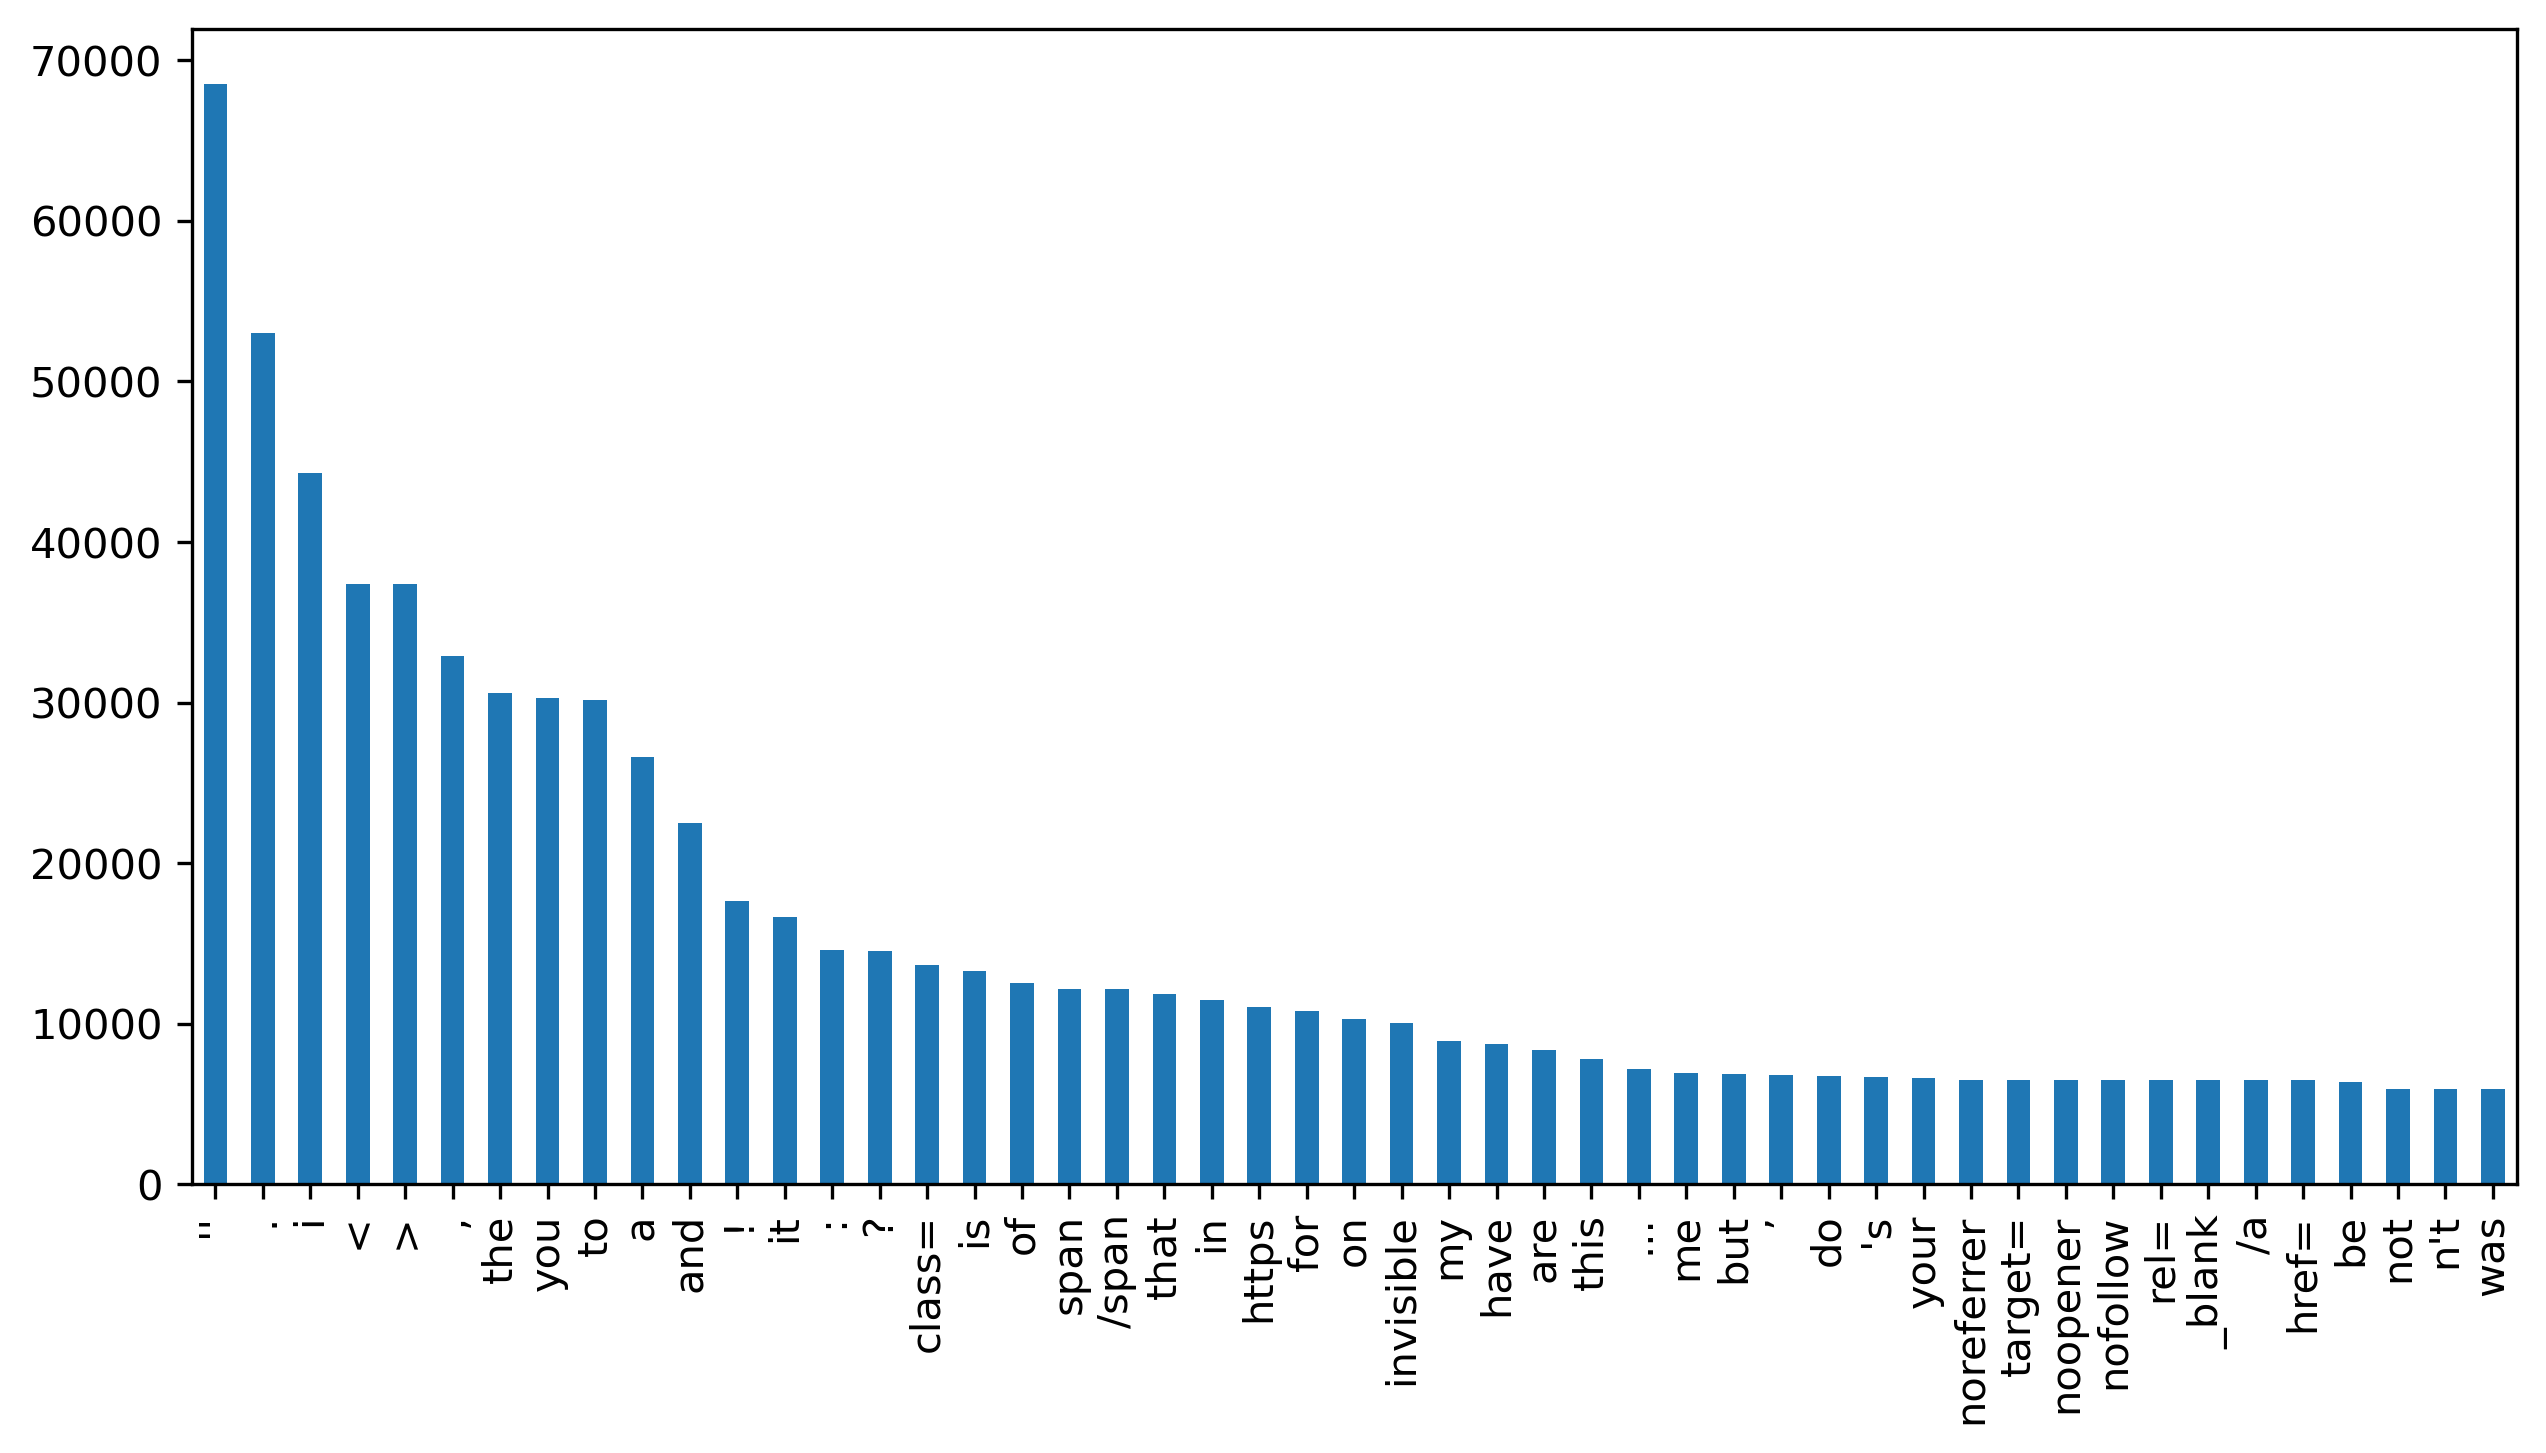

In [12]:
# Graph the top 50 words
counts.iloc[0:49].plot(kind='bar')

From the looks of it, there's a fair amount of HTML lurking in our corpus. I am going to put off making a decision about what to do about it for now. (Should it stay or should it go?, with apologies to The Clash.)

## DTM

Using the basic vectorizer set up we have discussed before, I changed the parameters and got the following results:

| Parameter      | Word Count | Notes |
|----------------|------------|-------|
| lowercase-only | 55,253     |  |
| stopwords      | 54,950     |  All subsequent tests have lower and stopwords.|
| min_df = 2     | 22,266     |   |
| min_df = 3     | 15,270     | Not sure which to go with |
| max_df = *     | 54,950     | Cranked this all way down to `0.5` and it remained the same. (Is this a product of lots of small texts?) |

In [25]:
# Vectorize our texts while removing function words
# and words that occur in only one text
vectorizer = CountVectorizer(lowercase = True,
                             max_df = 0.5,
                             stop_words='english')

# fit the model to the data 
matrix = vectorizer.fit_transform(texts)

# We'll need these later
vocabulary = vectorizer.get_feature_names_out()

# see how many features we have
matrix.shape

(70596, 54950)

Given these parametric results, I am going to try using `min_df=3` and run the TF-IDF vectorizer to see what a topic model might look like.

In [28]:
# Vectorize our texts while removing function words
# and words that occur in only one text
vectorizer = CountVectorizer(lowercase = True,
                             min_df = 3,
                             stop_words='english')

# fit the model to the data 
tfidf = vectorizer.fit_transform(texts)

# We'll need these later
vocabulary = vectorizer.get_feature_names_out()

# see how many features we have
tfidf.shape

(70596, 15270)

## K-Means Clustering

In [33]:
%%time

# We are going to run this up to 50 possible clusters
wcss = [] 
for i in range(1, 50): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(tfidf) 
    wcss.append(kmeans.inertia_)

CPU times: user 2min 47s, sys: 14.7 s, total: 3min 2s
Wall time: 23.5 s


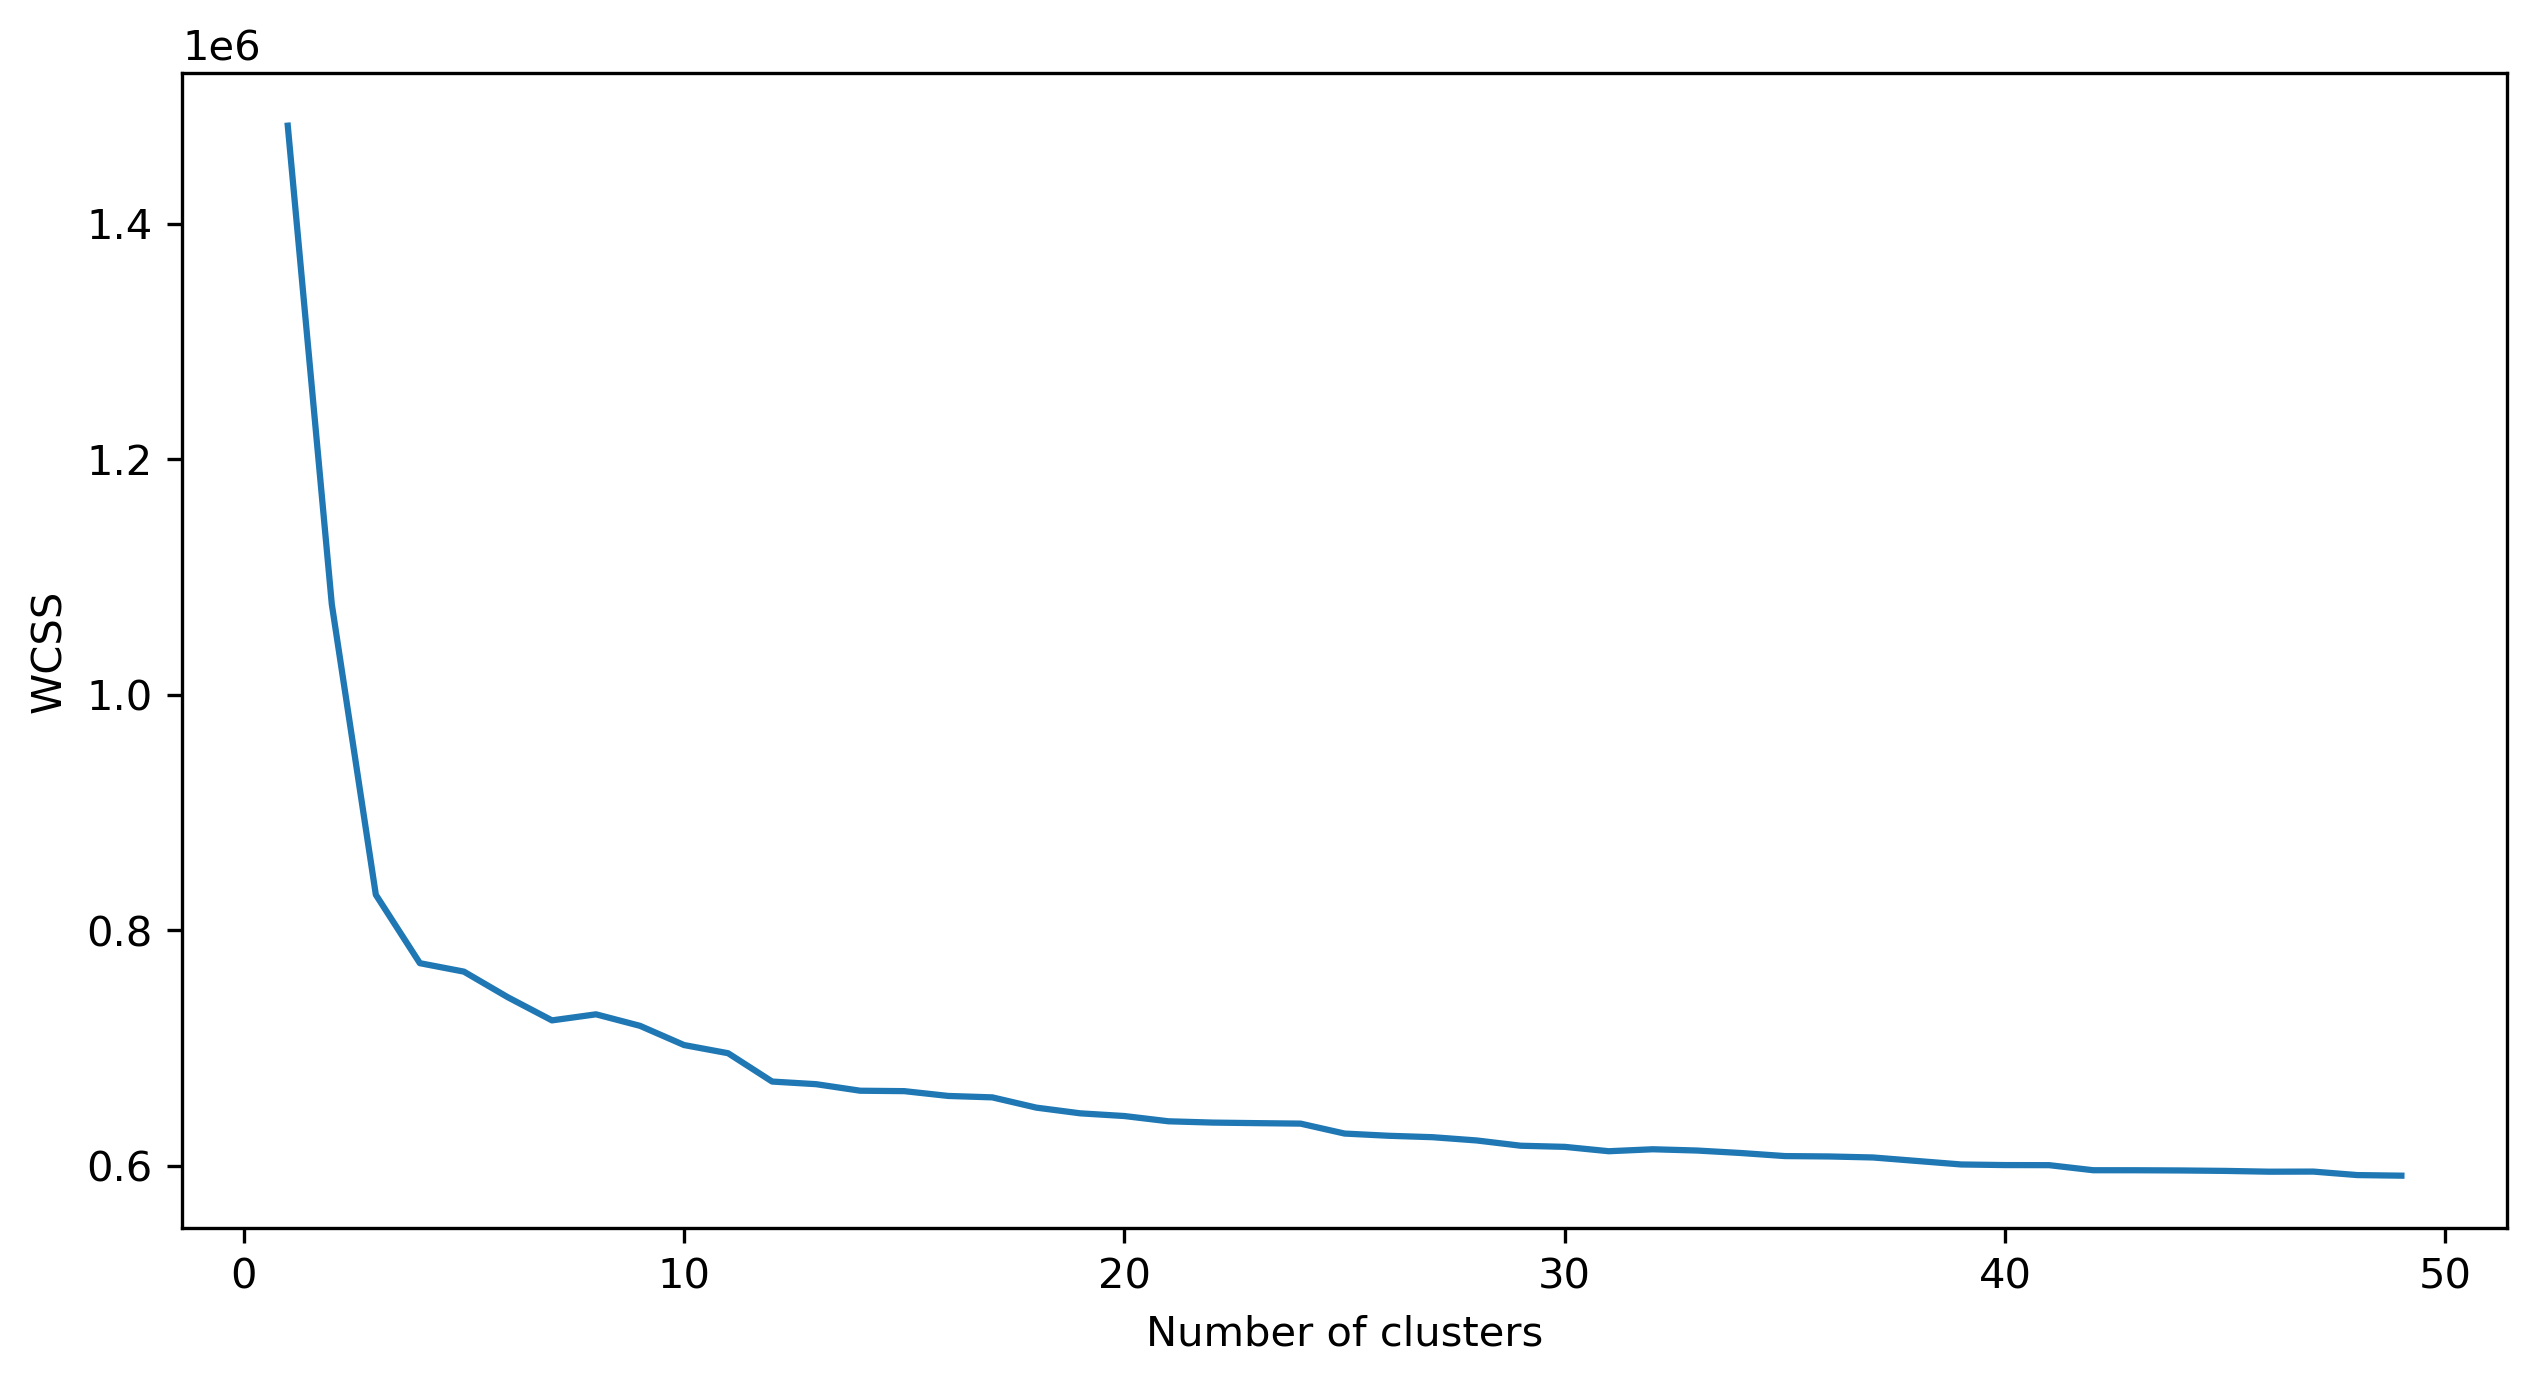

In [34]:
# Let's plot and we'll run this up through 50 possible clusters
plt.plot(range(1, 50), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

That would appear to be a pretty clear elbow at 4 or 5. (Let's hope this isn't a product of the HTML artifacts above.) 

In [36]:
%%time

nmf = NMF(n_components=5, 
          random_state=1, 
          max_iter=500, 
          init='nndsvd').fit(tfidf)
nmf_W = nmf.transform(tfidf)
nmf_H = nmf.components_
nmf_W.shape

CPU times: user 1.27 s, sys: 380 ms, total: 1.65 s
Wall time: 537 ms


(70596, 5)

In [37]:
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "{:d}: ".format(topic_idx)
        message += " ".join([feature_names[i] + ' ' + str(round(topic[i], 2)) + ','
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [38]:
display_topics(nmf, vocabulary, 10)

0: target 8.07, href 8.07, rel 8.07, _blank 8.07, nofollow 8.07, noopener 8.07, noreferrer 8.07, class 8.02, mention 8.01, gab 8.0,
1: span 16.66, class 7.9, invisible 6.91, https 6.32, com 4.73, target 3.03, noopener 3.03, _blank 3.03, nofollow 3.03, noreferrer 3.03,
2: amp 14.55, 2c 0.51, clouthub 0.5, watch 0.49, 22 0.48, youtube 0.47, 3a 0.42, 2f 0.42, com 0.35, www 0.35,
3: just 4.95, gab 3.94, know 3.71, like 3.49, don 2.48, people 2.09, time 1.56, good 1.53, think 1.49, want 1.43,
4: org 7.1, file 4.15, wikileaks 2.18, emails 1.08, clinton 1.07, mayfirst 0.59, fbclid 0.57, index 0.47, span 0.46, class 0.39,



At least the first two topics are HTML artifacts--there are also traces in the third topic, so we need to build a custom stopword list to get ride of those.